## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
(df.converted == True).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page' or group != 'treatment' and landing_page == 'new_page'").count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query("group == 'treatment' and landing_page != 'new_page' or group != 'treatment' and landing_page == 'new_page'").index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2['user_id'][df2.duplicated(['user_id'])]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(index=2893, inplace = True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
(df2.converted == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
cont_conv = (df2.query('group == "control"')['converted'] == 1)
cont_conv.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treat_conv = (df2.query('group == "treatment"')['converted'] == 1)
treat_conv.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**There isn't sufficient evidence to conclude that the new treatment page leads to more conversion rate since the statistical significance of the observed statistic hasn't been investigated yet.**

>**Conducting an A/B test without conducting a hypothesis testing won't tell us if the statistic from one A/B test has been obtained by random or it reflecte the true parameter of the population.**

>**It's also doubtful if the difference in the conversion rate between the old and the new pages are practically significant since it's less than 1 percent.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> $$H_{0}: P_{old} \geqslant P_{new}$$ $$H_{1}: P_{old} < P_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_null = df2.converted.mean()
p_null

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
#the same proportion is used since under the null hypothesis the new page has the same or less conversion rate
p_null

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1,p_null,n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1,p_null,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
new_page_converted = np.random.binomial(n_new, p_null, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_null, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

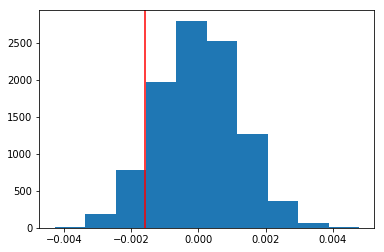

In [25]:
#the plot looks line it was expected to look - being normally distributed
diff = treat_conv.mean() - cont_conv.mean()
plt.hist(p_diffs);
plt.axvline(x=diff,color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [26]:
pval = (p_diffs > diff).mean()
pval

0.90490000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**The computed value is called 'p-value' - the probability of obtaining the observed statistic or the value more in favour of the alternative hypothesis assuming that the null hypothesis is true. In other words, it's the probability of commiting Type I error.**

>**That means the greater the p-value the more chances that the null-hypothesis is correct and shouldn't be rejected. The threshold of considering the p-value 'little enough' to reject the null hypothesis is determined by the alpha-level which is set at 0.05 according to the description of the task.**

>**In this case the p-value is 0.9 which means that we have 90% of commiting Type I error and 90% of chance the data is from the null value. The p-value is too high and we fail to reject the null hypothesis.**

>**Since the null hypothesis is not rejected we don't have any statistical evidence that the new page provides the greater conversion than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [27]:
%%capture 
#using the magic key word to supress the warning message
import statsmodels.api as sm

convert_old = cont_conv.sum()
convert_new = treat_conv.sum()
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [28]:
#finding z-statistic for the difference in the conversion rates considering that the p_new is larger than p_old
zstat,pval = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative = 'larger')
zstat,pval

(-1.3109241984234394, 0.90505831275902449)

In [29]:
#finding the critical value for the alpha = 0.05
from scipy import stats 
p = 1-0.05
value = stats.norm.ppf(p)
value

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**Z-score measures how many standard deviations a data point is far from the mean given that the data is distributed normally. In a z-test we use the z-statistic to estimate how many standard deviations 2 statistics are far from one another.**

>**In this case we measure how many standard deviations the conversion rate of the new page is far from the conversion rate of the old page given that the alternative hypothesis suggests that the old page has the smaller conversion rate. In the next step we find the critical value for the alpha-level = 0.05 which shows what the value of the z-statistic should be to consider the results statistically significant on that alpha-level.**

>**The obtained z-score (-1.31) is less than the critical value for the alpha-level of 0.05 (1.64) which means that we don't have enough evidence to reject the null hypothesis. The p-value has the same meaning in the z-test - the chance of commiting Type I error. These findings agree with the findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Since we're dealing with the binary data (converted or not converted) that means that the Logistic Regression will be the best choice.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df) #without adding this the error will be raised instead of printing the
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        05:47:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>**In the logit regression we calculated if there's any difference between the null hypothesis and the alternative hypothesis. The p-value of ab_page is 0.19. It differs from the p-value in Part II because we conducted 1-tailed test whereas in this part it's 2-sided test based on the next null and alternative hypotheses:**

>**$$H_{0}: P_{old} = P_{new}$$ $$H_{1}: P_{old} \neq P_{new}$$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It's always a good idea to look at the multiple factors to determine if there are any covert variables impacting the response. The main disadvantages of adding multiple variables is to obtain the results impacted by the Simpson's paradox which can lead us to the false conclusion about the data.**

>**Adding too many variables may lead to multicollinearity which therefore will have a negative impact on the model by making an impression that the response is affected by some variable whereas actually it's not.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
df4 = df2.join(df3.set_index('user_id'), on='user_id',how = 'inner')
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
df4[['CA','UK','US']] = pd.get_dummies(df4['country'])

In [36]:
logit_mod2 = sm.Logit(df4['converted'],df4[['intercept','UK','US']])
results2 = logit_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [37]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        05:47:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [38]:
1/np.exp(results2.params)

intercept    7.671651
UK           0.950546
US           0.960018
dtype: float64

>**We can see that there's no substantial difference in conversion rates between the countries compared to CA and the p-values of the countries are too high which makes the results statistically insignificant and we fail to reject the null hypothesis which means that country doesn't impact impact the conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df4['US_new'] = df4['US'] * df4['ab_page']
df4['UK_new'] = df4['UK'] * df4['ab_page']
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_new,UK_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [40]:
logit_mod3 = sm.Logit(df4['converted'],df4[['intercept','UK_new','US_new']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:               1.082e-05
Time:                        05:47:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
UK_new         0.0112      0.018      0.626      0.532      -0.024       0.046
US_new        -0.0144      0.012     -1.155      0.248      -0.039       0.010
==============================================================================
"""

In [41]:
1/np.exp(results3.params)

intercept    7.334699
UK_new       0.988834
US_new       1.014530
dtype: float64

>**Like in the test above we can't see any evidence from the interaction between a page and a country that the conversion rate is impacted by a country - the p-values are too high and the difference in conversion rate between the countries is insignificant.**

>**That means that we fail to reject the null hypothesis.**

### Conclusion:
**Since the new page hasn't demonstrated the substantional increase in the conversion rate and due to the statistical insignificance of the test results we can't say that the new page can increase the conversion rate therefore I would recommend continuing using the old page.** 

**Additional resources used:**

**[Explaining p-value](https://rebeccaebarnes.github.io/2018/05/01/what-is-a-p-value)**<br>
**[Explaining z-score](https://en.wikipedia.org/wiki/Standard_score)**<br>
**[Explaining z-test](https://en.wikipedia.org/wiki/Z-test)**<br>
**[Finding critical values for z-score in Python](https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/)**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0